In [5]:
# commented out imports to run on nathan's pc
# from aiohttp import web
import socketio

import os
import base64
from io import BytesIO
import json
import jsonpickle

import cv2
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

import glob
import re
import copy

# from gel_tools import GelAnalysis

In [6]:
# Choose folder
gel_image_folder = "2022_Summer_Intern/Gel_Images/nathan_gels/Q_1/raw"  # make sure that the segmentation map filenames are identical to image filenames or this won't work!
ilastic_folder = "2022_Summer_Intern/Gel_Images/nathan_gels/Q_1/segmentation"
qupath_folder = "2022_Summer_Intern/QuPath_Nathan_Q1_Test_Two_Images/predictionImage"

# set foreground/background colour
foreground_colour = (255,0,0)
background_colour = (0,255,0)

In [7]:
def extract_image_names_from_folder(folder, sorted=True, recursive=False):
    filenames = []
    for extension in ['*.jpg', '*.png', '*.bmp', '*.tif']:
        if recursive:
            glob_path = os.path.join(folder, '**', extension)
        else:
            glob_path = os.path.join(folder, extension)
        filenames.extend(glob.glob(glob_path, recursive=recursive))
    if sorted:
        # Sort file names in Natural Order so that numbers starting with 1s don't take priority
        filenames.sort(key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])
    return filenames

def load_segmentation_maps_and_images(gel_image_folder, ilastic_folder, qupath_folder):
    images = []

    # gets original images
    gel_files = extract_image_names_from_folder(gel_image_folder, sorted=True, recursive=True)
    
    image_names = [os.path.basename(file).split('.')[0] for file in gel_files]  # gets image names by splitting off file extension e.g. .tif 
    
    # gets ilastic segmentation maps
    ilastic_files = extract_image_names_from_folder(ilastic_folder, sorted=True, recursive=True)
    
    # gets QuPath segmentation maps
    qupath_files = extract_image_names_from_folder(qupath_folder, sorted=True, recursive=True)
        
    data_dict = {}  # prepares dictionary to collect all required info
    
    for gel_file, ilastic_file, qupath_file, image_name in zip(gel_files, ilastic_files, qupath_files, image_names):
        
        gel_img = cv2.imread(gel_file)  # read images
        ilastic_img = cv2.imread(ilastic_file)
        qupath_img = cv2.imread(qupath_file)
        
        # np.all = finds elements in array where condition is met, the axis argument (-1 = final dimension i.e. number 2) is telling the system to confirm a match when all three elements match the target colour.
        ilastic_img[np.all(ilastic_img == (1,1,1), axis=-1)] = foreground_colour  # replacing foreground in segmentation map

        ilastic_img[np.all(ilastic_img == (2,2,2), axis=-1)] = background_colour  # replacing background in segmentation map
        
        qupath_img[np.all(qupath_img == (13,106,163), axis=-1)] = foreground_colour  # replacing foreground in segmentation map

        qupath_img[np.all(qupath_img == (166,21,139), axis=-1)] = background_colour  # replacing background in segmentation map
        
        # Ilastic:  fg: (1,1,1)      bg: (2,2,2)
        # QuPath:   fg: (13,106,163) bg: (166,21,139)

        data_dict[image_name] = [gel_img, ilastic_img, qupath_img]  # packaging data into dictionary (the key is the image title)
    
    return data_dict

In [8]:
data_dict = load_segmentation_maps_and_images(gel_image_folder, ilastic_folder, qupath_folder)

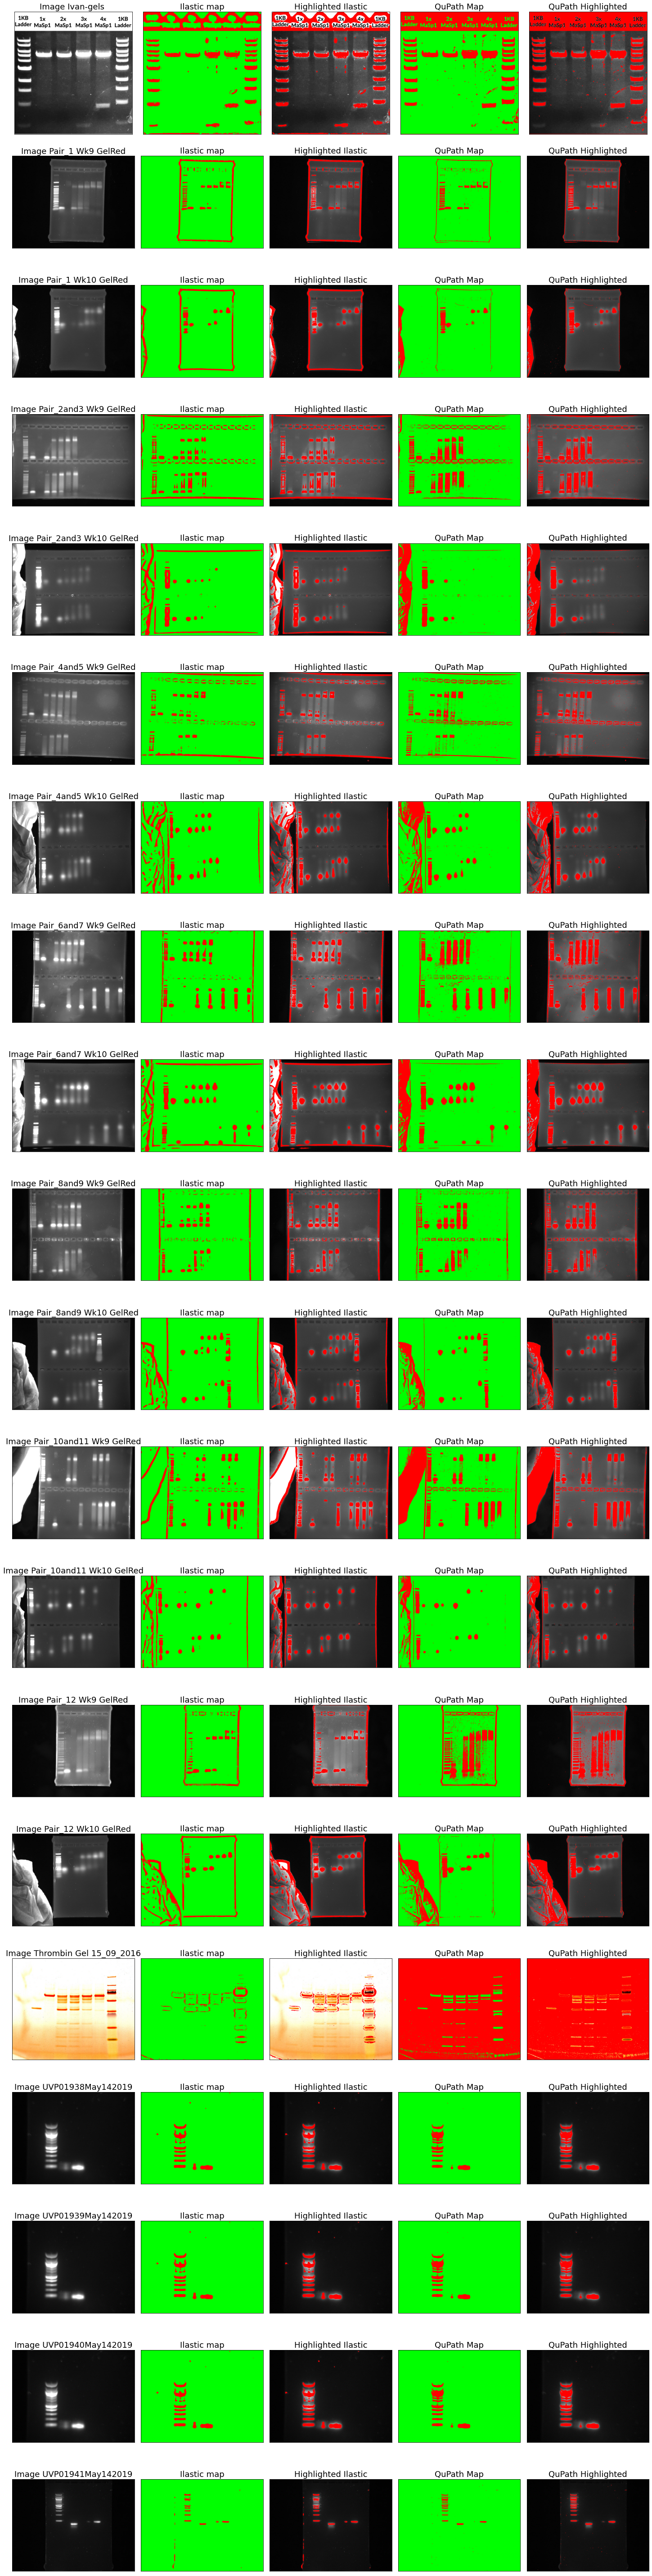

In [10]:
# Change the vertical height (2nd argument of figsize) to increase image size
fig, axs = plt.subplots(len(data_dict), 5,figsize=(20,80)) # this figsize should be enough.

fontsize = 18  # title fonts

"""Check if need to change this for loop"""
for index, (image_name, data) in enumerate(data_dict.items()):
    
    # original image in column 1
    axs[index, 0].imshow(data[0])
    axs[index,0].set_title('Image %s' % image_name, fontsize=fontsize)
    axs[index,0].axes.xaxis.set_visible(False)
    axs[index,0].axes.yaxis.set_visible(False)
    
    # ilastic segmented image in column 2
    axs[index,1].imshow(data[1]) # , aspect='auto'
    #axs[index,1].set_title('Ilastic Segmentation map for image %s' % image_name, fontsize=fontsize)
    axs[index,1].set_title('Ilastic map', fontsize=fontsize)
    axs[index,1].axes.xaxis.set_visible(False)
    axs[index,1].axes.yaxis.set_visible(False)
    
    # combined ilastic segmentation map + image in column 3
    
    combi_map_ilastic = copy.copy(data[0])  # if this is not done, value inside dictionary will be directly modified
    
    combi_map_ilastic[np.all(data[1] == foreground_colour, axis=-1)] = foreground_colour 

    axs[index,2].imshow(combi_map_ilastic) # , aspect='auto'
    #axs[index,2].set_title('Ilastic Image %s with foreground highlighted' % image_name, fontsize=fontsize)
    axs[index,2].set_title('Highlighted Ilastic', fontsize=fontsize)
    axs[index,2].axes.xaxis.set_visible(False)
    axs[index,2].axes.yaxis.set_visible(False)
    
    # qupath segmented image in column 4
    axs[index,3].imshow(data[2]) # , aspect='auto'
    #axs[index,3].set_title('QuPath Segmentation map for image %s' % image_name, fontsize=fontsize)
    axs[index,3].set_title('QuPath Map', fontsize=fontsize)
    axs[index,3].axes.xaxis.set_visible(False)
    axs[index,3].axes.yaxis.set_visible(False)
    
    # combined qupath segmentation map + image in column 5
    
    combi_map_qupath = copy.copy(data[0])  # if this is not done, value inside dictionary will be directly modified
    
    combi_map_qupath[np.all(data[2] == foreground_colour, axis=-1)] = foreground_colour 

    axs[index,4].imshow(combi_map_qupath) # , aspect='auto'
    #axs[index,4].set_title('Ilastic Image %s with foreground highlighted' % image_name, fontsize=fontsize)
    axs[index,4].set_title('QuPath Highlighted', fontsize=fontsize)
    axs[index,4].axes.xaxis.set_visible(False)
    axs[index,4].axes.yaxis.set_visible(False)
    
fig.tight_layout()  # helps even out spacing between images and fills up all available space

In [11]:
fig.savefig('nathan_Q1_Comparison.pdf')  # save to pdf as this will ensure a good output.  Later, we might use pngs if pdfs are not suitable.